In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
import time
import json
from keras import regularizers
from keras import backend as K
import numpy as np
from sklearn.model_selection import StratifiedKFold
K.tensorflow_backend._get_available_gpus()

import datetime

import pandas as pd
import os
from os import path
import configparser
import re
import sys
# for training
from sklearn.model_selection import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [0]:
import pandas as pd
import os
from os import path
import configparser
import re
sep = os.sep


class PreProcessing():
    def __init__(self):
        self._train_path = "/content/drive/My Drive/Data/rent-prediction/train.csv"
        self._test_path = "/content/drive/My Drive/Data/rent-prediction/test.csv"
        self._sample_submit_path = "/content/drive/My Drive/Data/rent-prediction/sample_submit.csv"

        self._train = pd.read_csv(self._train_path)
        self._test = pd.read_csv(self._test_path)
        self._sample_submit = pd.read_csv(self._sample_submit_path)

    def process(self, data):
        location = data['所在地']
        access = data['アクセス']
        layout = data['間取り']
        build_time = data['築年数']
        direction = data['方角']
        area = data['面積']
        floor = data['所在階']
        bath_toilet = data['バス・トイレ']
        kitchen = data['キッチン']
        communication = data['放送・通信']
        equipment = data['室内設備']
        parking = data['駐車場']
        environment = data['周辺環境']
        structure = data['建物構造']
        contract = data['契約期間']

        # process
        data['アクセス'] = self.process_access(data['アクセス'])
        data['間取り'] = self.process_layout(data['間取り'])
        data['築年数'] = self.process_build_time(data['築年数'])
        data['面積'] = self.process_area(data['面積'])
        data['建物構造'] = self.process_structure(data['建物構造'])
        data['バス・トイレ'] = self.process_bath_toilet(data['バス・トイレ'])
        data['方角'] = self.process_direction(data['方角'])

        drop_columns = ['id', '所在地', '契約期間', 'キッチン', '放送・通信', '周辺環境', '所在階', '室内設備', '駐車場']
        data.drop(drop_columns, axis=1, inplace=True)
        data = data.astype("float64")
        return data

    def get_train_data(self):
        dataset = self.process(self._train)
        label = dataset['賃料']
        train = dataset.drop('賃料', axis=1)
        train = self.norm(train)
        return train, label

    def get_test_data(self):
        test = self.process(self._test)
        test = self.norm(test)
        return test

    @staticmethod
    def norm(dataset):
        stats = dataset.describe()
        stats = stats.transpose()
        return (dataset - stats["mean"]) / stats["std"]

    @staticmethod
    def process_area(area):
        area = area.str.replace("m2", "")
        area.astype("float32")
        return area

    @staticmethod
    def process_build_time(build_time):
        def build_time_f_str(x):
            str_arr = x.split(".")
            year = int(str_arr[0])
            month = 0
            if len(str_arr) > 1:
                month = int(str_arr[1])
            return year * 12 + month
        build_time = build_time.str.replace("年", ".")
        build_time = build_time.str.replace("ヶ月", "")
        build_time = build_time.str.replace("新築", "0")
        # 築（月）数　　大きければ大きいほど悪い
        build_time = build_time.map(build_time_f_str)
        return build_time

    @staticmethod
    def process_access(access):
        def take_min_number_in_text(text):
            pattern = r'([0-9]*)'
            lists = re.findall(pattern, text)
            number_list = []
            for item in lists:
                if item.isdigit():
                    number_list.append(item)
            return int(min(number_list))
        access = access.map(take_min_number_in_text)
        return access

    @staticmethod
    def process_layout(layout):
        layout_level = {'1R': 1, '1K': 2, '1K+S(納戸)': 3, '1DK': 4, '1DK+S(納戸)': 5,
                        '1LK+S(納戸)': 6, '1LDK': 7, '1LDK+S(納戸)': 8,
                        '2R':6, '1LK': 5,
                        '2K': 9, '2K+S(納戸)': 10, '2DK': 11, '2DK+S(納戸)': 12,
                        '2LDK': 13, '2LDK+S(納戸)': 14,
                        '3K': 15, '3K+S(納戸)': 16, '3DK': 17, '3DK+S(納戸)': 18,
                        '3LDK': 19, '3LDK+S(納戸)': 20,
                        '4K': 21, '4DK': 22, '4LDK': 23, '4LDK+S(納戸)': 24, '4DK+S(納戸)': 24,
                        '5K': 25, '5DK': 26, '5DK+S(納戸)': 27, '5LDK': 28,
                        '5LDK+S(納戸)': 29, '6LDK': 30,
                        '6K':31,'6DK':31, '6LDK+S(納戸)':31,'8LDK':32, '11R':1}

        def map_layout_level(key):
            if key is not None:
                return layout_level[key]
            else:
                return None

        layout = layout.map(map_layout_level)
        return layout

    @staticmethod
    def process_structure(structure):
        structure_level = {
            'RC（鉄筋コンクリート）': 9, '鉄骨造': 8, '木造': 7, 'SRC（鉄骨鉄筋コンクリート）': 6, '軽量鉄骨': 5,
            'ALC（軽量気泡コンクリート）': 4, 'その他': 0, 'PC（プレキャスト・コンクリート（鉄筋コンクリート））': 3,
            'HPC（プレキャスト・コンクリート（重量鉄骨））': 2, 'ブロック': 1,
            '鉄筋ブロック': 8,
        }

        def map_structure_level(key):
            if key is not None:
                return structure_level[key]
            else:
                return None

        structure = structure.map(map_structure_level)
        return  structure

    @staticmethod
    def process_bath_toilet(bath_toilet):
        def function_str(text):
            point_map = {"専用バス": 1,
                         "専用トイレ": 1,
                         "バス・トイレ別": 1,
                         "シャワー": 1,
                         "追焚機能": 1,
                         "浴室乾燥機": 1,
                         "温水洗浄便座": 1,
                         "洗面台独立": 1,
                         "脱衣所": 1,
                         "共同トイレ": -1,
                         }
            total_point = 0
            if type(text) is str:
                arr = text.split("／\t")
                for item in arr:
                    if item in point_map.keys():
                        total_point += point_map[item]
            return total_point
        return bath_toilet.map(function_str)

    @staticmethod
    def process_direction(direction):
        def function_str_direction(text):
            direction_level = {
                '南東': 3, '南': 3, '東': 2, '北西': 1, '西': 1, '北': 1, '南西': 1, '北東': 2}
            if text in direction_level.keys():
                return direction_level[text]
            else:
                return 0

        return direction.map(function_str_direction)

instance = PreProcessing()
train, label = instance.get_train_data()
test_data = instance.get_test_data()

In [0]:
    def nn_train(train_data):
        # model
        layer_numbers = 256

        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true)))

            # mean_squared_logarithmic_error, mean_absolute_percentage_error, mean_absolute_error
        loss = root_mean_squared_error

        def build_model(dataset):
            model = keras.Sequential([
                layers.Dense(128,  kernel_initializer='normal', input_shape=[len(dataset.keys())],
                             activation=tf.nn.relu),
                layers.Dense(layer_numbers, kernel_initializer='normal', activation=tf.nn.relu),
                layers.Dense(layer_numbers, kernel_initializer='normal', activation=tf.nn.relu),
                layers.Dense(layer_numbers, kernel_initializer='normal', activation=tf.nn.relu),
                layers.Dense(1, kernel_initializer='normal', activation='linear')
            ])
            # optimizer = tf.keras.optimizers.RMSprop(0.001)
            optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
            model.compile(
                loss = loss,
                optimizer=optimizer,
                metrics=["mean_squared_error", "mean_absolute_percentage_error"],
            )
            return model

        model = build_model(train_data)

        # if os.path.isfile("param_goto.hdf5"):
        #     model.load_weights('param_goto.hdf5')

        model.summary()
        # example trainning
        example_batch = train_data[:10]
        example_result = model.predict(example_batch)
        example_result

        return model

In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.plot(hist["epoch"], hist["loss"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_loss"], label="Val Error")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Percentage Error")
    plt.plot(hist["epoch"], hist["mean_absolute_percentage_error"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mean_absolute_percentage_error"], label="Val Error")
    plt.legend()
    plt.show()

In [0]:

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("")
        print(".", end="")


In [0]:
# callback when NG
      EPOCHS = 1000

      start_time = time.time()
      # The patience parameter is the amount of epochs to check for improvement
      early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=100)

      model = nn_train(train)
      
      if os.path.isfile("/content/drive/My Drive/Data/rent-prediction/param_goto.hdf5"):
        model.load_weights('/content/drive/My Drive/Data/rent-prediction/param_goto.hdf5')

      history = model.fit(train, label, batch_size=128, epochs=EPOCHS, shuffle=True,
                          validation_data=(train, label), verbose=2,
                          callbacks=[early_stop, PrintDot()])
      end_time = time.time()
      execute_time = end_time - start_time
      print("execute time: {}".format(execute_time))
      plot_history(history)

      # save model
      json_string = model.to_json()
      with open('/content/drive/My Drive/Data/rent-prediction/model_goto.json', 'w') as outfile:
          json.dump(json_string, outfile)

      # save weight
      model.save_weights('/content/drive/My Drive/Data/rent-prediction/param_goto.hdf5')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________
Train on 31470 samples, validate on 31470 samples
Epoch 1/1000

.31470/31470 - 2s - loss: 76442.3930 - mean_square

In [0]:
def save_submit(prediction):
      sample_submit_path = "/content/drive/My Drive/Data/rent-prediction/sample_submit.csv"
      submit = pd.read_csv(sample_submit_path, header=None)
      submit[1] = prediction
      now = datetime.datetime.now()
      now_str = '{}_{}_{}_{}_{}'.format(now.year, now.month, now.day, now.hour, now.minute)
      submit_folder = "/content/drive/My Drive/Data/rent-prediction/submit"
      if not os.path.exists(submit_folder):
          os.mkdir(submit_folder)
      submit_file = submit_folder + '/submit_{}.csv'.format(now_str)
      submit.to_csv(submit_file, header=None, index=None)


In [0]:
prediction = model.predict(test_data)
print(prediction)
save_submit(prediction)


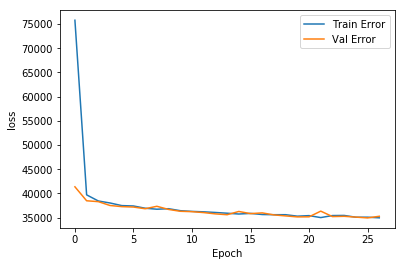

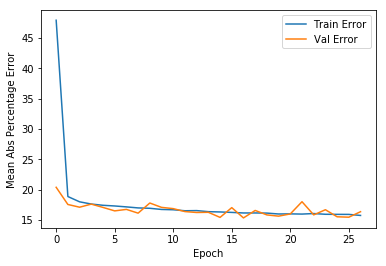